<div class="clearfix" style="padding: 10px; padding-left: 0px">
<a href="https://www.kaggle.com/c/nips-2017-non-targeted-adversarial-attack"><img src="https://raw.githubusercontent.com/tensorflow/cleverhans/master/assets/logo.png" width="150px" style="display: inline-block; margin-top: 65px;"></img></a>
<a href="http://linkedin.com/in/corypruce/"><img src="https://sep.yimg.com/ay/fridgedoor/caution-jazz-hands-magnet-4.gif" width="150px" class="pull-right" style="display: inline-block; margin: 0px;" ></img></a>
</div>
# Battle Jazz GANs!!

In [169]:
import os
import sys
import numpy as np
import torch
import torchvision
import torch.utils.data as data
from scipy.misc import imsave
import matplotlib
import matplotlib.pyplot as plt 
import os.path
import pandas as pd
import torchvision.transforms as transforms
from inception_v3 import *

from PIL import Image

from torch import autograd
from torch.autograd.gradcheck import zero_gradients
from helpers import *

import hashlib
import io

%matplotlib inline

# What's cool about Generative Adversarial Networks?!

<br>
**The obvious**: a person today can train a generative model easily, with the goal of fooling the best discriminators. In this notebook, I'll do a short demonstration of this scenario, using InceptionV3 pretrained on ImageNet.  
<br>
**The not-so-obvious**: the generative model that is produced becomes a pretty good creator of high-dimensional data from the underlying distribution [3]. Generative models will be an extremely useful tool in the near-future where acquiring a large dataset is infeasible. For example, a dataset of a large variety of styles can be produced for image recognition tasks or states, actions, and rewards produced for reinforcement learning. Perhaps generative models will be able to help simulate complex physical events we haven't been able to before. 
<br><br>
**The obviously cool**: combining deep learning and game theory/reinforcement learning in a highly applicable fashion. Inception of Machine Learning Security, highlighting the infancy of modern-day models and techniques. Spam bots can possibly generate successfully masquerading emails. Fake information can maybe be produced en masse. Moreover, since the generator(s) in GANs learn the joint probability distribution, they have the ability to make "guesses" at missing labeled data aka *semi-supervised learning*.
<br><br><br>
The following is a configuration which will allow for a fast convergence of both the non-targeted and the targeted attack using rwightman's Fast Gradient port of the Tensorflow example. I am also working on publishing the non-targeted Virtual Adversarial Training (VAT) attack as an addition.


Thanks for foundations and inspiration: <br>
https://arxiv.org/pdf/1701.00160.pdf<br>
https://www.kaggle.com/c/nips-2017-targeted-adversarial-attack/discussion/37614<br>
https://www.kaggle.com/allunia/example-attacking-logistic-regression<br>
https://www.kaggle.com/benhamner/adversarial-learning-challenges-getting-started<br>
http://pytorch.org/docs/0.2.0/_modules/torchvision/models/inception.html<br>
https://github.com/znxlwm/pytorch-generative-model-collections/blob/master/<br>
https://github.com/charlesjansen/Deep-Learning-face_generation/blob/master/dlnd_face_generation.ipynb<br>


In [170]:
IMG_EXTENSIONS = ['.png', '.jpg']

class LeNormalize(object):
    """Normalize to -1..1 in Google Inception style
    """
    def __call__(self, tensor):
        for t in tensor:
            t.sub_(0.5).mul_(2.0)
        return tensor


def default_inception_transform(img_size):
    tf = transforms.Compose([
        transforms.Scale(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        LeNormalize(),
    ])
    return tf


def find_inputs(folder, filename_to_target=None, types=IMG_EXTENSIONS):
    inputs = []
    for root, _, files in os.walk(folder, topdown=False):
        for rel_filename in files:
            base, ext = os.path.splitext(rel_filename)
            if ext.lower() in types:
                abs_filename = os.path.join(root, rel_filename)
                target = filename_to_target[rel_filename.split('.')[0]] if filename_to_target else 0
                inputs.append((abs_filename, target))
    return inputs


class Dataset(data.Dataset):

    def __init__(
            self,
            root,
            target_file='target_class.csv',
            transform=None):
        
        if target_file:
            target_file_path = target_file #os.path.join(root, target_file)
            target_df = pd.read_csv(target_file_path)#, header=None)
            target_df["TargetClass"] = target_df["TargetClass"].apply(int)
            #print(target_df["ImageId"], target_df["TargetClass"])
            f_to_t = dict(zip(target_df["ImageId"], target_df["TargetClass"] - 1))  # -1 for 0-999 class ids
        else:
            f_to_t = dict()

        imgs = find_inputs(root, filename_to_target=f_to_t)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if target is None:
            target = torch.zeros(1).long()
        return img, target

    def __len__(self):
        return len(self.imgs)

    def set_transform(self, transform):
        self.transform = transform

    def filenames(self, indices=[], basename=False):
        if indices:
            if basename:
                return [os.path.basename(self.imgs[i][0]) for i in indices]
            else:
                return [self.imgs[i][0] for i in indices]
        else:
            if basename:
                return [os.path.basename(x[0]) for x in self.imgs]
            else:
                return [x[0] for x in self.imgs]

class OneShotDataset(data.Dataset):

    def __init__(
            self,
            filename,
            transform=None):

        self.filename = filename
        self.transform = transform

    def __getitem__(self, index):
        path = self.filename
        target = None
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if target is None:
            target = torch.zeros(1).long()
        return img, target

    def __len__(self):
        return 1

The below is a variation of rwightman's port of the base Iterative-Fast Gradient Sign Method (I-FGSM) for non-targeted attacks: $$x^{adv} = x + \epsilon * sign(\nabla_{x}(J(x,y_{true}))) $$ <br> and the Iterative-Targeted Fast Gradient Sign Method (I-TFGSM) for targeted attacks: $$x^{adv} = x - \epsilon * sign(\nabla_{x}(J(x,y_{fake})))$$ <br> which leverage the $\ell_{\inf}-norm$ solely for input image $x$. Each are computed $num\_steps$ times.[1] <br>

One notable difference between my choice of $y_{fake}$ and [1]'s pick is that my selection of attack targets are randomly selected, where as [1] seems to pick the *least-likely* from the original image softmax output.

In [171]:
class AttackIterative:

    def __init__(
            self,
            max_epsilon=16, norm=float('inf'), step_alpha=None, 
            num_steps=None, cuda=True, debug=False):

        self.eps = 2.0 * max_epsilon / 255.0
        self.num_steps = num_steps or 10
        self.norm = norm
        if not step_alpha:
            if norm == float('inf'):
                self.step_alpha = self.eps / self.num_steps
            else:
                # Different scaling required for L2 and L1 norms to get anywhere
                if norm == 1:
                    self.step_alpha = 500.0  # L1 needs a lot of (arbitrary) love
                else:
                    self.step_alpha = 1.0
        else:
            self.step_alpha = step_alpha
        self.loss_fn = torch.nn.CrossEntropyLoss()
        if cuda:
            self.loss_fn = self.loss_fn.cuda()
        self.debug = debug

    def non_target_attack(self, non_target_model, x, targets, batch_idx=0):
        input_var = autograd.Variable(x, requires_grad=True)
        targets_var = autograd.Variable(targets)
        eps = self.eps
        step_alpha = self.step_alpha

        step = 0
        while step < self.num_steps:
            zero_gradients(input_var)
            output = non_target_model(input_var)
            if not step:
                # for non-targeted, we'll move away from most likely
                targets_var.data = output.data.max(1)[1]
            loss = self.loss_fn(output, targets_var)
            loss.backward()

            # normalize and scale gradient
            if self.norm == 2:
                normed_grad = step_alpha * input_var.grad.data / l2_norm(input_var.grad.data)
            elif self.norm == 1:
                normed_grad = step_alpha * input_var.grad.data / l1_norm(input_var.grad.data)
            else:
                # infinity-norm
                normed_grad = step_alpha * torch.sign(input_var.grad.data)

            # perturb current input image by normalized and scaled gradient
            step_adv = input_var.data + normed_grad

            # calculate total adversarial perturbation from original image and clip to epsilon constraints
            total_adv = step_adv - x
            total_adv = torch.clamp(total_adv, -eps, eps)
            
            if self.debug:
                print('Non-Targeted --', 'batch:', batch_idx, 'step:', step, total_adv.mean(), total_adv.min(), total_adv.max())
                sys.stdout.flush()

            # apply total adversarial perturbation to original image and clip to valid pixel range
            input_adv = x + total_adv
            input_adv = torch.clamp(input_adv, -1.0, 1.0)
            input_var.data = input_adv
            step += 1

        return input_adv.permute(0, 2, 3, 1).cpu().numpy()
    
    def target_attack(self, target_model, x, targets, batch_idx=0):
        input_var = autograd.Variable(x, requires_grad=True)
        targets_var = autograd.Variable(targets)
        eps = self.eps
        step_alpha = self.step_alpha

        step = 0
        while step < self.num_steps:
            zero_gradients(input_var)
            output = target_model(input_var)
            loss = self.loss_fn(output, targets_var)
            loss.backward()

            # normalize and scale gradient
            if self.norm == 2:
                normed_grad = step_alpha * input_var.grad.data / l2_norm(input_var.grad.data)
            elif self.norm == 1:
                normed_grad = step_alpha * input_var.grad.data / l1_norm(input_var.grad.data)
            else:
                # infinity-norm
                normed_grad = step_alpha * torch.sign(input_var.grad.data)

            # perturb current input image by normalized and scaled gradient
            step_adv = input_var.data - normed_grad

            # calculate total adversarial perturbation from original image and clip to epsilon constraints
            total_adv = step_adv - x
            total_adv = torch.clamp(total_adv, -eps, eps)
            
            if self.debug:
                print('Targeted --', 'batch:', batch_idx, 'step:', step, total_adv.mean(), total_adv.min(), total_adv.max())
                sys.stdout.flush()

            # apply total adversarial perturbation to original image and clip to valid pixel range
            input_adv = x + total_adv
            input_adv = torch.clamp(input_adv, -1.0, 1.0)
            input_var.data = input_adv
            step += 1

        return input_adv.permute(0, 2, 3, 1).cpu().numpy()
        
    def run(self, non_target_model, target_model, x, true_targets, fake_targets, batch_idx=0):
        non_target_pred = self.non_target_attack(non_target_model, x, true_targets, batch_idx=0)
        target_pred = self.target_attack(target_model, x, fake_targets, batch_idx=0)
        return (non_target_pred, target_pred)

In [172]:
def make_prediction(model, output_file):
    dataset = OneShotDataset(
            output_file,
            transform=default_inception_transform(args["img_size"]))
    loader = data.DataLoader(
        dataset,
        batch_size=1)
    # one shot
    for _batch_idx, (tensor, _target) in enumerate(loader): 
        input_var = autograd.Variable(tensor, requires_grad=True)
        zero_gradients(input_var)
        output = model(input_var)
        _, preds = torch.max(output.data, 1)
    return preds

In [173]:
def make_md5(img_file):
    m = hashlib.md5()
    img = Image.open(img_file)
    with io.BytesIO() as memf:
        img.save(memf, 'PNG')
        data = memf.getvalue()
        m.update(data)
    return m.hexdigest()

def display_attacks(attacks, fake_targets, cols):
    f, axs = plt.subplots(nrows=len(attacks),ncols=3,figsize=(15,22))
    cat_df = pd.read_csv('categories.csv')
    
    for ax, col in zip(axs[0], cols):
        ax.annotate(col, xy=(0.5, 1.1), xytext=(0, 1),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
    for i, row in enumerate(axs):
        for j, col in enumerate(row):
            img, label, md5 = attacks[i][j]
            col.imshow(img)
            target = cat_df.iloc[label-1][1].split(",")[0]
            title = 'Labeled: '+target
            if j == 2:
                fake_target = cat_df.iloc[fake_targets[i]-1][1].split(",")[0]
                title += '. Target: '+fake_target
            col.set_title(title)
            col.annotate('MD5: '+md5, xy=(0.5, -0.12), xytext=(0, 1),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    plt.show()

In [174]:
import torchvision.models
import matplotlib.image as mpimg
def run_iterative_attack(args, attack):
    assert args["input_dir"]

    dataset = Dataset(
        args["input_dir"],
        transform=default_inception_transform(args["img_size"]))

    loader = data.DataLoader(
        dataset,
        batch_size=args["batch_size"],
        shuffle=False)

    # train from scratch
    non_target_gen_model = inception_v3(pretrained=False, transform_input=True)
    target_gen_model     = inception_v3(pretrained=False, transform_input=True)
    if args["cuda"]:
        non_target_gen_model = non_target_gen_model.cuda()
        target_gen_model     = target_gen_model.cuda()

    # pick up feature hierarchy from checkpoint
    if args["checkpoint_path"] is not None and os.path.isfile(args["checkpoint_path"]):
        checkpoint = torch.load(args["checkpoint_path"])
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            non_target_gen_model.load_state_dict(checkpoint['state_dict'])
            target_gen_model.load_state_dict(checkpoint['state_dict'])
        else:
            non_target_gen_model.load_state_dict(checkpoint)
            target_gen_model.load_state_dict(checkpoint)
    else:
        print("Error: No checkpoint found at %s." % args["checkpoint_path"])

    non_target_gen_model.eval()
    target_gen_model.eval()
    
    # pretrained discriminatory model
    dis_model = inception_v3(pretrained=True)
    dis_model.eval()
    
    attacks = []                        
    # run both non-targeted and targeted attacks
    for batch_idx, (input, true_targets) in enumerate(loader):    
        start_index = args["batch_size"] * batch_idx
        indices = list(range(start_index, start_index + input.size(0)))

        # spawn 4 random classes. For one batch (size=4), unlikely fake==true (4/1000=1/250)
        fake_targets = np.random.randint(1, 1001 + 1, size=4)
        fake_targets = torch.from_numpy(fake_targets)
        
        if args["cuda"]:
            input = input.cuda()
            true_targets = true_targets.cuda()
            fake_targets = fake_targets.cuda()

        (non_target_adv, target_adv) = attack.run(non_target_gen_model, target_gen_model, 
                                                  input, true_targets, fake_targets, batch_idx)
        
        for i, (filename, non_target_o, target_o) in enumerate(
            zip(dataset.filenames(indices, basename=True), non_target_adv, target_adv)):
            # get and save non-targeted adversary image, label, and hash
            non_target_img = (non_target_o + 1.0) * 0.5
            non_target_output_file = os.path.join(args["output_dir"], "non_target_" + filename)
            imsave(non_target_output_file, non_target_img, format='png')     
            non_target_hash  = make_md5(non_target_output_file)
            non_target_label = make_prediction(dis_model, non_target_output_file)[0]
            
            # get and save targeted adversary image, label, and hash
            target_img = (target_o + 1.0) * 0.5
            target_output_file = os.path.join(args["output_dir"], "target_" + filename)
            imsave(target_output_file, target_img, format='png')     
            target_hash  = make_md5(target_output_file)
            target_label = make_prediction(dis_model, target_output_file)[0]
            
            # get original image, label, and hash
            og_img = mpimg.imread(args["input_dir"]+filename)
            og_file = os.path.join(args["input_dir"], filename)
            og_label = make_prediction(dis_model, og_file)[0]
            og_hash  = make_md5(og_file)
            attacks.append(((og_img, og_label, og_hash), 
                            (non_target_img, non_target_label, non_target_hash), 
                            (target_img, target_label, target_hash)))
              
        # only one batch for the notebook
        display_attacks(attacks, fake_targets, cols=["Original","Non-Targeted", "Targeted"])
        break 

In [175]:
args = {}
args["targeted"]=True
args["input_dir"]='input/'
args["max_epsilon"]=5 # serves the purpose of the demo
args["norm"]=0 
args["step_alpha"]=0.01
args["num_steps"]=10 
args["debug"]=False
args["img_size"]=299
args["batch_size"]=4
args["checkpoint_path"]='checkpoints/inception_v3_google-1a9a5a14.pth'
args["no_gpu"]=False
args["output_dir"]="output/"
args["cuda"]=False # quick run on laptop

/Users/cory/Kaggle/CleverHans/JazzGANs/inception_v3.py:66: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


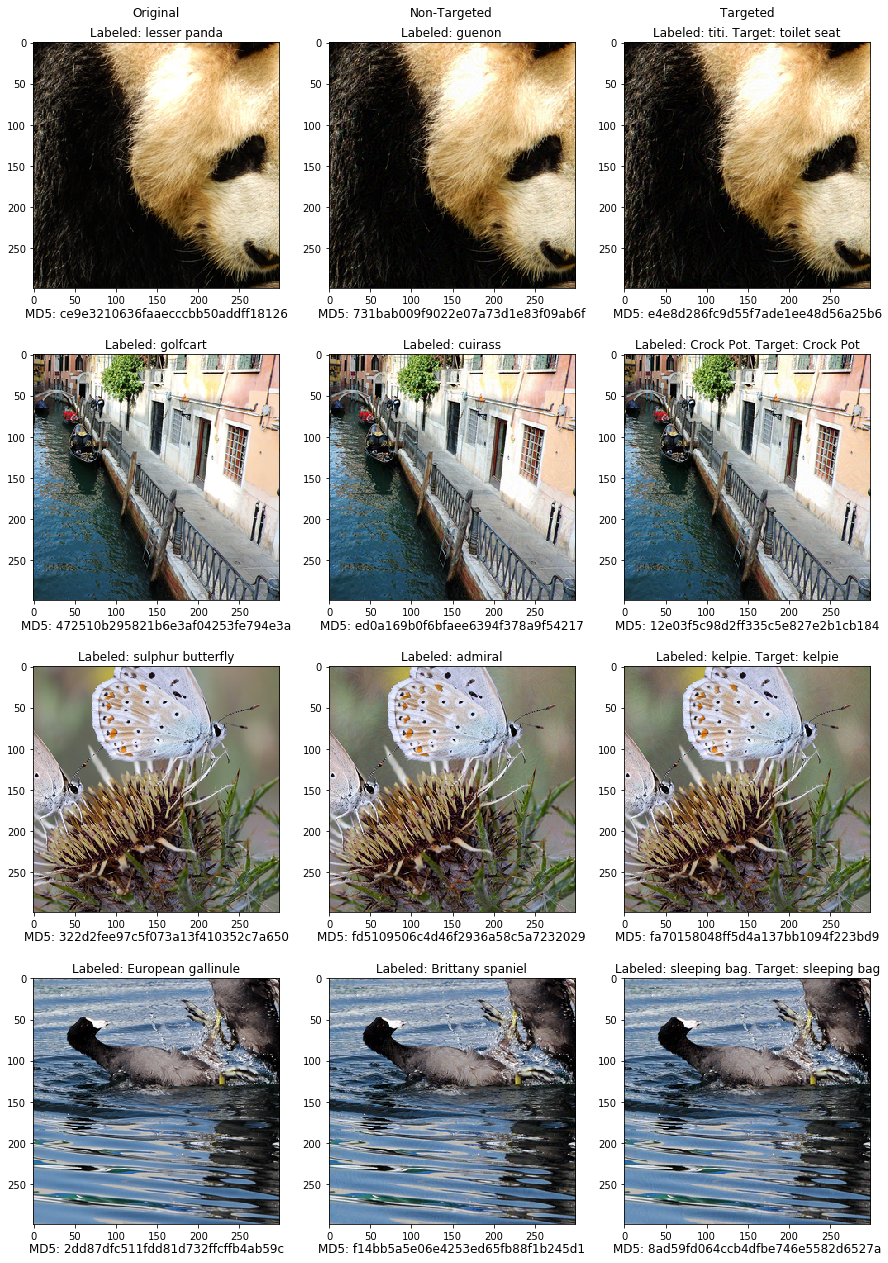

In [176]:
attack = AttackIterative(
        max_epsilon=args["max_epsilon"],
        norm=args["norm"],
        step_alpha=args["step_alpha"],
        num_steps=args["num_steps"],
        cuda=args["cuda"],
        debug=args["debug"])

#print(torchvision.models.__dict__)
run_iterative_attack(args, attack)

In [ ]:
##### In Progress ##### 
def kl_with_logits(p_logits, q_logits, scope=None,
                   loss_collection=tf.GraphKeys.REGULARIZATION_LOSSES):
    """Helper function to compute kl-divergence KL(p || q)
    """
    with tf.name_scope(scope, "kl_divergence") as name:
        p = tf.nn.softmax(p_logits)
        p_log = tf.nn.log_softmax(p_logits)
        q_log = tf.nn.log_softmax(q_logits)
        loss = tf.reduce_mean(tf.reduce_sum(p * (p_log - q_log), axis=1),
                              name=name)
        tf.losses.add_loss(loss, loss_collection)
    return loss

class AttackVirtual:
    # https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py#L102
    def __init__(
            self, eps, logits, num_steps, num_iterations=1, 
            xi=1e-6, cuda=True, debug=False):

        self.eps = 2.0 * max_epsilon / 255.0
        self.num_steps = num_steps
        self.num_iterations = num_iterations
        self.logits = logits
        self.xi = xi
        self.loss_fn = torch.nn.CrossEntropyLoss()
        if cuda:
            self.loss_fn = self.loss_fn.cuda()
        self.debug = debug
        
   def run(self, model, x, batch_idx=0):
        
        input_var = autograd.Variable(x, requires_grad=True)
        eps = self.eps
        w = torch.Tensor(*x.size()).zero_()
        d = torch.init.normal(w)
        d_var = autograd.Variable(d, requires_grad=True)
        
        for i in range(num_iterations):
            zero_gradients(input_var)
            zero_gradients(d_var)
            #d = xi * utils_tf.l2_batch_normalize(d)
            d_var = xi * torch.nn.functional.normalize(d_var, p=2) #batch_norm()
            #logits_d = model.get_logits(x + d)
            output = model(input_var+d_var)
            kl = kl_with_logits(d_var, output.data) #logits, logits_d)
            Hd = tf.gradients(kl, d)[0]
            d = tf.stop_gradient(Hd)
            
        d_var = eps * torch.nn.functional.normalize(d_var, p=2) #utils_tf.l2_batch_normalize(d)
        adv_x = input_var + d_var

        # return adv_x
        
        #################
        step = 0
        while step < self.num_steps:
            
            output = non_target_model(input_var)
            
            
            if not step:
                # for non-targeted, we'll move away from most likely
                targets_var.data = output.data.max(1)[1]
            loss = self.loss_fn(output, targets_var)
            loss.backward()

            # normalize and scale gradient
            if self.norm == 2:
                normed_grad = step_alpha * input_var.grad.data / l2_norm(input_var.grad.data)
            elif self.norm == 1:
                normed_grad = step_alpha * input_var.grad.data / l1_norm(input_var.grad.data)
            else:
                # infinity-norm
                normed_grad = step_alpha * torch.sign(input_var.grad.data)

            
                
                
            # perturb current input image by normalized and scaled gradient
            step_adv = input_var.data + normed_grad

            # calculate total adversarial perturbation from original image and clip to epsilon constraints
            total_adv = step_adv - input
            total_adv = torch.clamp(total_adv, -eps, eps)
            
            if self.debug:
                print('Non-Targeted --', 'batch:', batch_idx, 'step:', step, total_adv.mean(), total_adv.min(), total_adv.max())
                sys.stdout.flush()

            # apply total adversarial perturbation to original image and clip to valid pixel range
            input_adv = input + total_adv
            input_adv = torch.clamp(input_adv, -1.0, 1.0)
            input_var.data = input_adv
            step += 1

        return input_adv.permute(0, 2, 3, 1).cpu().numpy()

[1] Tramèr, Florian, et al. "Ensemble Adversarial Training: Attacks and Defenses." arXiv preprint arXiv:1705.07204 (2017). <br>
[2] Miyato, Takeru, et al. "Distributional smoothing with virtual adversarial training." arXiv preprint arXiv:1507.00677 (2015).<br>
[3] Goodfellow, Ian. "NIPS 2016 tutorial: Generative adversarial networks." arXiv preprint arXiv:1701.00160 (2016).